In [1]:
! pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [8]:
!cp kaggle.json ~/.kaggle/

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! mkdir dataset

In [6]:
! kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.02G/2.04G [00:19<00:00, 126MB/s]
100% 2.04G/2.04G [00:19<00:00, 114MB/s]


In [7]:
! unzip plantvillage-dataset -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993

In [10]:
#Rename the folder, because the original one has space in it
! rm -rf /content/dataset/plantvillagedataset/segmented

In [11]:
! rm -rf /content/dataset/plantvillagedataset/grayscale

In [12]:
! pip install split-folders

In [13]:
! split-folders dataset/plantvillagedataset/color --output dataset --ratio .7 .1 .2

Copying files: 54305 files [00:16, 3372.15 files/s]


In [14]:
! rm -rf dataset/plantvillagedataset

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

In [16]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
diseases = sorted(os.listdir('dataset/train'))

# Extract plant names from disease categories
plant_names = [category.split('___')[0] for category in diseases]

# Count unique plant names
unique_plants = set(plant_names)
num_plants = len(unique_plants)

print("Number of unique plant categories:", num_plants)
print("\nUnique plant categories:", unique_plants)

Number of unique plant categories: 14

Unique plant categories: {'Blueberry', 'Pepper,_bell', 'Raspberry', 'Strawberry', 'Soybean', 'Grape', 'Corn_(maize)', 'Tomato', 'Apple', 'Potato', 'Orange', 'Cherry_(including_sour)', 'Squash', 'Peach'}


In [18]:
diseases

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [19]:
#Declaring constants
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32

In [20]:
#Training Data pipeline
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],  # Adjust brightness randomly between 0.8 and 1.2
    channel_shift_range=0.2,      # Randomly shift color channels
)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode='sparse'
)

Found 37997 images belonging to 38 classes.


In [21]:
#Setting the number of classes
class_names = train_generator.class_indices.keys()
class_names = list(class_names)
n_classes = len(class_names)

In [22]:
#Validation Data Pipeline
validation_datagen = ImageDataGenerator(
    rescale = 1.0/255,
)

validation_generator = validation_datagen.flow_from_directory(
    'dataset/val',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse'
)

Found 5417 images belonging to 38 classes.


In [23]:
#Test Data Pipeline
test_datagen = ImageDataGenerator(
    rescale = 1.0/255
)

test_generator = validation_datagen.flow_from_directory(
    'dataset/test',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse'
)

Found 10891 images belonging to 38 classes.


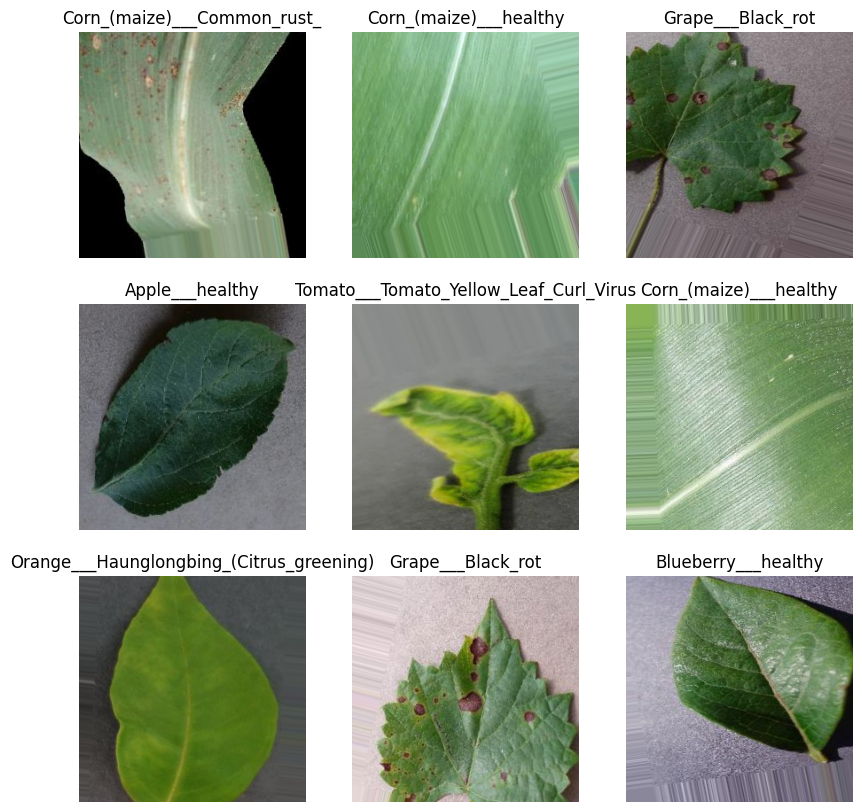

In [24]:
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(class_names[int(sample_labels[i])])  # Convert to integer before using as index
    plt.axis('off')
plt.show()

In [26]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top = False, input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS), pooling = 'max')

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(
    Adamax(learning_rate=0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE
    ),
    metrics = ['accuracy']
)

In [27]:
 history = model.fit(
    x = train_generator,
    validation_data = validation_generator,
    epochs=4,
    verbose=1,
    validation_steps=None,
    shuffle=False
)

Epoch 1/4
1188/1188 [==============================] - 1152s 936ms/step - loss: 0.8024 - accuracy: 0.7912 - val_loss: 0.0967 - val_accuracy: 0.9730
Epoch 2/4
1188/1188 [==============================] - 1094s 921ms/step - loss: 0.1986 - accuracy: 0.9493 - val_loss: 0.0805 - val_accuracy: 0.9790
Epoch 3/4
1188/1188 [==============================] - 1060s 892ms/step - loss: 0.1175 - accuracy: 0.9704 - val_loss: 0.0371 - val_accuracy: 0.9910
Epoch 4/4
1188/1188 [==============================] - 1054s 887ms/step - loss: 0.0938 - accuracy: 0.9771 - val_loss: 0.0355 - val_accuracy: 0.9911


In [28]:
#Xception history
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

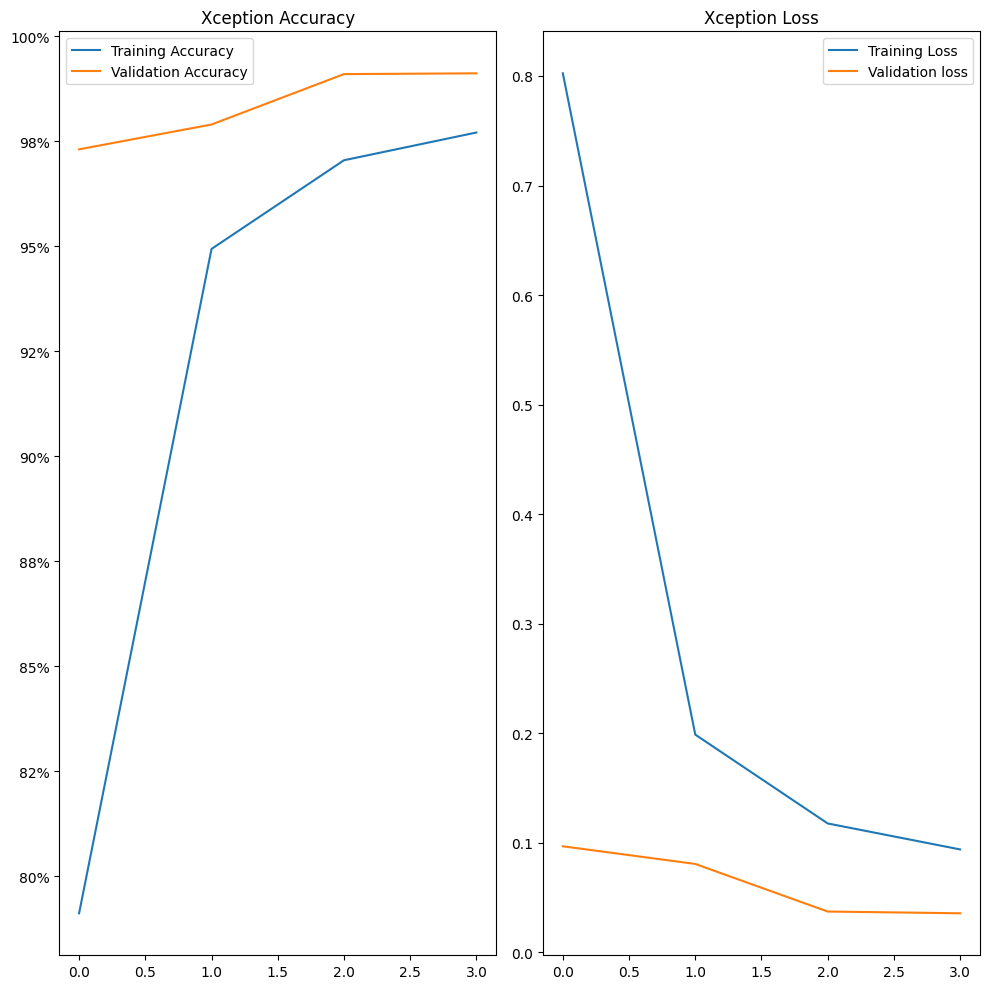

In [30]:
from matplotlib.ticker import FuncFormatter

def to_percentage(y, _):
    return '{:.0%}'.format(y)


plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend()
plt.title("Xception Accuracy")
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))

plt.subplot(1,2,2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = "Validation loss")
plt.title("Xception Loss")
plt.legend()

plt.tight_layout()
plt.show()

Actual label:  Tomato___Target_Spot
1/1 [==============================] - 0s 51ms/step

Xception Predicted label:  Tomato___Target_Spot
Confidence:  0.9993579


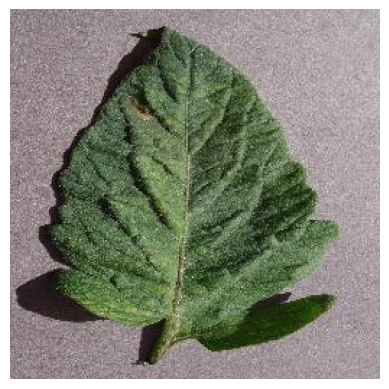

In [35]:
import numpy as np

for image_batch, label_batch in test_generator:
    image = image_batch[0]
    label = int(label_batch[0])

    plt.imshow(image)
    print("Actual label: ", class_names[label])

    batch_prediction = model.predict(image_batch)
    image_prediction = batch_prediction[0]
    print("\nXception Predicted label: ", class_names[np.argmax(image_prediction)])
    print("Confidence: ", np.max(image_prediction))

    plt.axis('off')
    break

In [36]:
!mkdir models

In [37]:
model.save('/content/models/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
